In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [10]:
# tushare读数据
import tushare as ts
ts.set_token('0742c95bee169abeccdf80bbdce1b2e0cf2ac4d83cbd932b608300fd')
pro = ts.pro_api()
tickers = pro.index_weight(index_code='000905.SH', trade_date=20210630, 
                        fields=["con_code"])["con_code"].to_list()
                        
def get_returns(tickers, start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns

In [11]:
#数据准备

start = '20230301'
end = '20230307'

returns = get_returns(tickers, start, end)

In [12]:
for date in returns.index:
    plt.hist(returns.loc[date], bins=50)
    plt.title('date:{}'.format(date))
    plt.show()

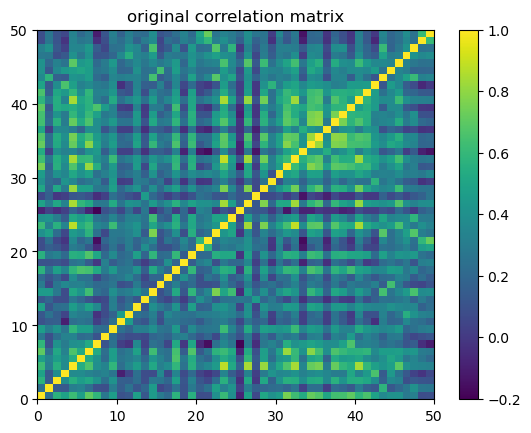

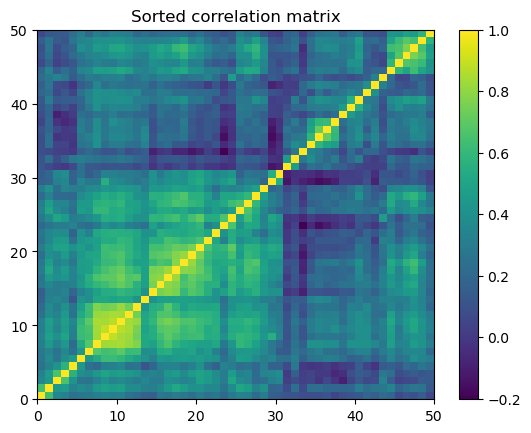

In [16]:
returns = (returns - returns.mean())/returns.std() 
### 分层聚类--使得相关系数大的股票离得更近
corr = returns.corr(method='pearson')   #股票returns的相关系数
plt.pcolormesh(corr)
plt.colorbar()
plt.title('original correlation matrix')
plt.show()
dist = 1 - corr.values
tri_a, tri_b = np.triu_indices(len(dist), k=1)
linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward') # 最短最长平均法做层次聚类
permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
sorted_stocks = returns.columns[permutation]
sorted_corrs = corr.values[permutation, :][:, permutation]
sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强 
plt.pcolormesh(sorted_correlations)
plt.colorbar()
plt.title('Sorted correlation matrix')
plt.show()

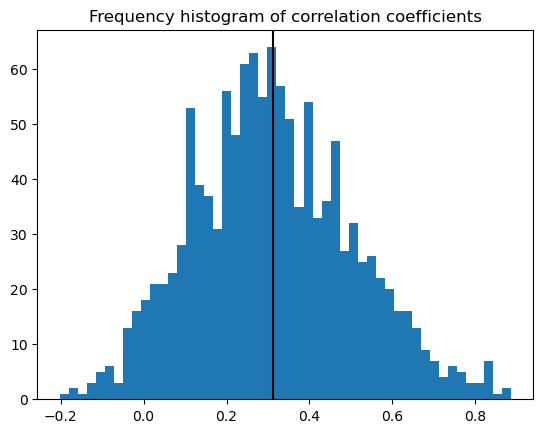

In [17]:
### 相关系数频数分布直方图
returns = returns[sorted_correlations.columns.tolist()]
corr = returns.corr().values
tri_a, tri_b = np.triu_indices(len(corr), k=1)
flat_corr = corr[tri_a, tri_b]
plt.hist(flat_corr, bins=50)
plt.axvline(flat_corr.mean(), color='k')
plt.title('Frequency histogram of correlation coefficients')
plt.show()

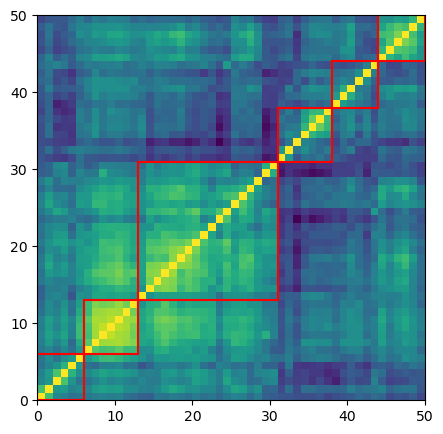

Cluster 1
size: 6
['600547.SH', '601899.SH', '600028.SH', '601857.SH', '601088.SH', '600104.SH']


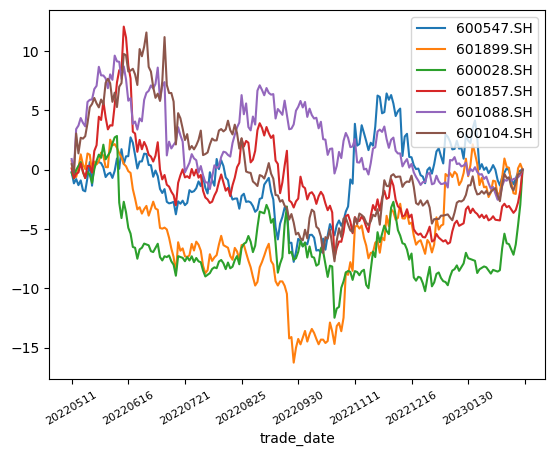

Cluster 2
size: 7
['601995.SH', '600918.SH', '601211.SH', '600837.SH', '600030.SH', '601688.SH', '601066.SH']


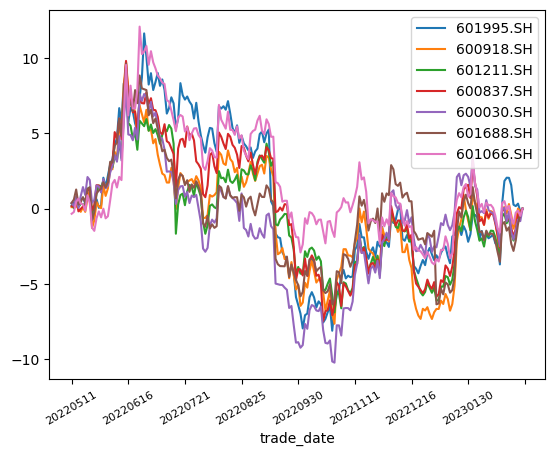

Cluster 3
size: 18
['601138.SH', '601628.SH', '601601.SH', '601336.SH', '601318.SH', '600036.SH', '601166.SH', '600000.SH', '601818.SH', '600016.SH', '600048.SH', '601668.SH', '600031.SH', '600585.SH', '600690.SH', '600309.SH', '601288.SH', '601398.SH']


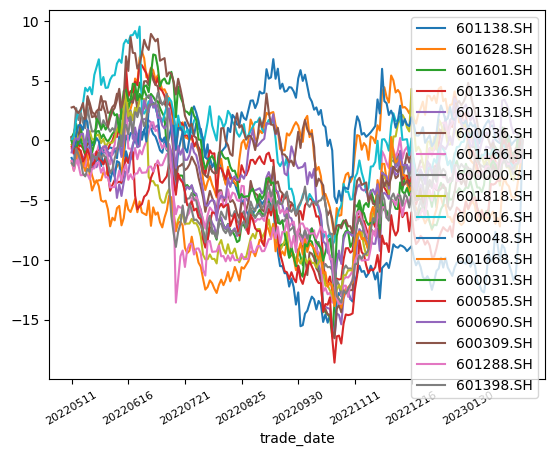

Cluster 4
size: 7
['601012.SH', '600438.SH', '600893.SH', '600703.SH', '600745.SH', '603986.SH', '603501.SH']


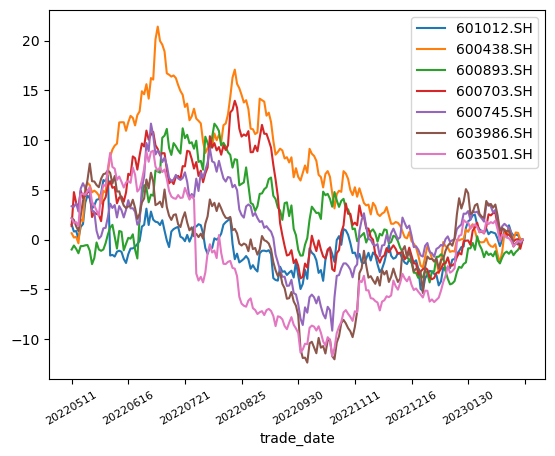

Cluster 5
size: 6
['600196.SH', '600276.SH', '603259.SH', '600570.SH', '600588.SH', '600050.SH']


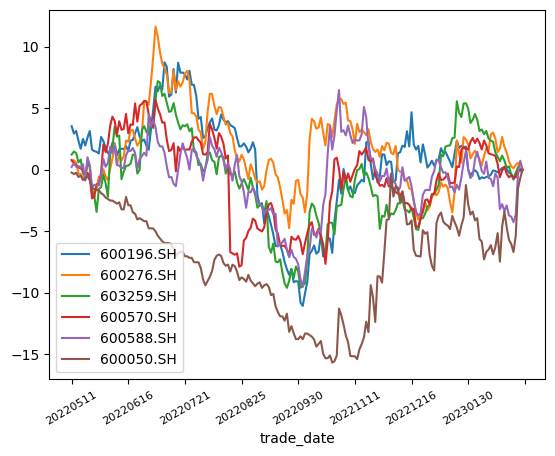

Cluster 6
size: 6
['600887.SH', '603288.SH', '600809.SH', '600519.SH', '601888.SH', '600009.SH']


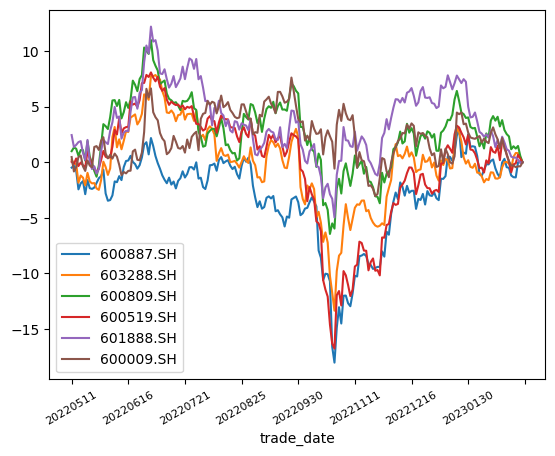

In [18]:
### 根据sorted_correlations将股票分成若干簇  注意！如果没有明显的资产分组，HPCA会加强一个虚假的结构
nb_clusters = 6
dist = 1 - sorted_correlations.values
dim = len(dist)
tri_a, tri_b = np.triu_indices(dim, k=1)
linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
clustering_inds = hierarchy.fcluster(linkage, nb_clusters,
                                     criterion='maxclust')
clusters = {i: [] for i in range(min(clustering_inds),
                                 max(clustering_inds) + 1)}
for i, v in enumerate(clustering_inds):
    clusters[v].append(i)

permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                     key=lambda x: x[0], reverse=False)
sorted_clusters = {}
for cluster in clusters:
    sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    
plt.figure(figsize=(5, 5))
plt.pcolormesh(sorted_correlations)
for cluster_id, cluster in sorted_clusters.items():
    xmin, xmax = min(cluster), max(cluster)
    ymin, ymax = min(cluster), max(cluster)
    
    plt.axvline(x=xmin,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axvline(x=xmax + 1,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axhline(y=ymin,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
    plt.axhline(y=ymax + 1,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
plt.show()

# 画每簇的成员股票累计收益率 簇内股票收益率相关性强 累计收益率曲线相似 注意！若相关系数不大，曲线不相似，可以增大簇的个数
stock_to_cluster = {}
for cluster in sorted_clusters:
    print('Cluster', cluster)
    cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
    for stock in cluster_members:
        stock_to_cluster[stock] = cluster
    print(f'size: {len(cluster_members)}')
    print(cluster_members)
    returns[cluster_members].cumsum().plot(legend=(len(cluster_members) < 20))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()


In [19]:
sorted_correlations.columns

Index(['600547.SH', '601899.SH', '600028.SH', '601857.SH', '601088.SH',
       '600104.SH', '601995.SH', '600918.SH', '601211.SH', '600837.SH',
       '600030.SH', '601688.SH', '601066.SH', '601138.SH', '601628.SH',
       '601601.SH', '601336.SH', '601318.SH', '600036.SH', '601166.SH',
       '600000.SH', '601818.SH', '600016.SH', '600048.SH', '601668.SH',
       '600031.SH', '600585.SH', '600690.SH', '600309.SH', '601288.SH',
       '601398.SH', '601012.SH', '600438.SH', '600893.SH', '600703.SH',
       '600745.SH', '603986.SH', '603501.SH', '600196.SH', '600276.SH',
       '603259.SH', '600570.SH', '600588.SH', '600050.SH', '600887.SH',
       '603288.SH', '600809.SH', '600519.SH', '601888.SH', '600009.SH'],
      dtype='object')

In [12]:
sorted_correlations.columns

Index(['600547.SH', '601899.SH', '600028.SH', '601857.SH', '601088.SH',
       '600104.SH', '601995.SH', '601688.SH', '601211.SH', '600837.SH',
       '600030.SH', '600918.SH', '601066.SH', '601398.SH', '601288.SH',
       '601138.SH', '601818.SH', '600016.SH', '600031.SH', '600585.SH',
       '600000.SH', '601668.SH', '600048.SH', '601628.SH', '601601.SH',
       '601336.SH', '601318.SH', '601166.SH', '600036.SH', '600690.SH',
       '600309.SH', '600009.SH', '603288.SH', '600519.SH', '600809.SH',
       '601888.SH', '600887.SH', '600050.SH', '600588.SH', '600570.SH',
       '603259.SH', '600276.SH', '600196.SH', '600893.SH', '600703.SH',
       '600745.SH', '603986.SH', '603501.SH', '600438.SH', '601012.SH'],
      dtype='object')

In [7]:
### 簇内股票收益率矩阵 右乘 簇内相关系数矩阵的第一特征向量 除以 最大特征值的平方 得收益率降维后的值
eigen_clusters = {}
for cluster in clusters:
    cluster_members = sorted_correlations.columns[
        sorted_clusters[cluster]].tolist()
    corr_cluster = sorted_correlations.loc[
        cluster_members, cluster_members]
    
    cluster_returns = returns[cluster_members]
    
    eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values) # 簇内相关系数的特征值、特征向量
    
    idx = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]

    val1, vec1= eigenvals[0], eigenvecs[:, 0] # 簇内相关系数的最大特征值、第一特征向量

    F1 = (1 / np.sqrt(val1)) * np.dot(cluster_returns.values,vec1) # 得簇内收益率降维后的值 392*10 × 10*1 = 392*1  将股票收益率整合到方差最大的线性方向上
    
    eigen_clusters[cluster] = {
        'tickers': cluster_members,
        'val1': val1,
        'vec1': vec1,
        'F1': F1,}
    

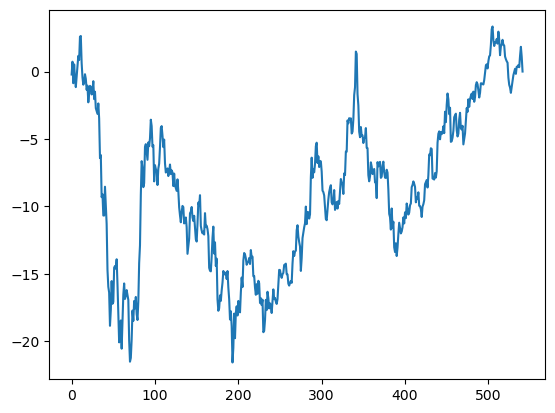

In [8]:
plt.plot(eigen_clusters[1]['F1'].cumsum())
plt.show()

In [9]:
# 股票收益率和对应簇内降维收益率的线性回归斜率
betas = {}
for stock in returns.columns:
    
    stock_returns = returns[stock]
    cluster_F1 = eigen_clusters[stock_to_cluster[stock]]['F1']
    
    reg = LinearRegression(fit_intercept=False).fit(
        cluster_F1.reshape(-1, 1), stock_returns)
    
    beta = reg.coef_[0]
    
    betas[stock] = beta 

In [10]:
### 更新不同簇的股票之间的相关系数 体现出簇间相关性
HPCA_corr = sorted_correlations.copy()
for stock_1 in HPCA_corr.columns:
    beta_1 = betas[stock_1]
    F1_1 = eigen_clusters[stock_to_cluster[stock_1]]['F1']
    for stock_2 in HPCA_corr.columns:
        beta_2 = betas[stock_2]
        F1_2 = eigen_clusters[stock_to_cluster[stock_2]]['F1']
        if stock_to_cluster[stock_1] != stock_to_cluster[stock_2]: # 对不同簇股票的相关系数调整 体现簇间差异
            rho_sector = np.corrcoef(F1_1, F1_2)[0, 1] # 簇间相关性
            mod_rho = beta_1 * beta_2 * rho_sector
            HPCA_corr.at[stock_1, stock_2] = mod_rho

In [11]:
min(HPCA_corr.min())

0.008651276391973507

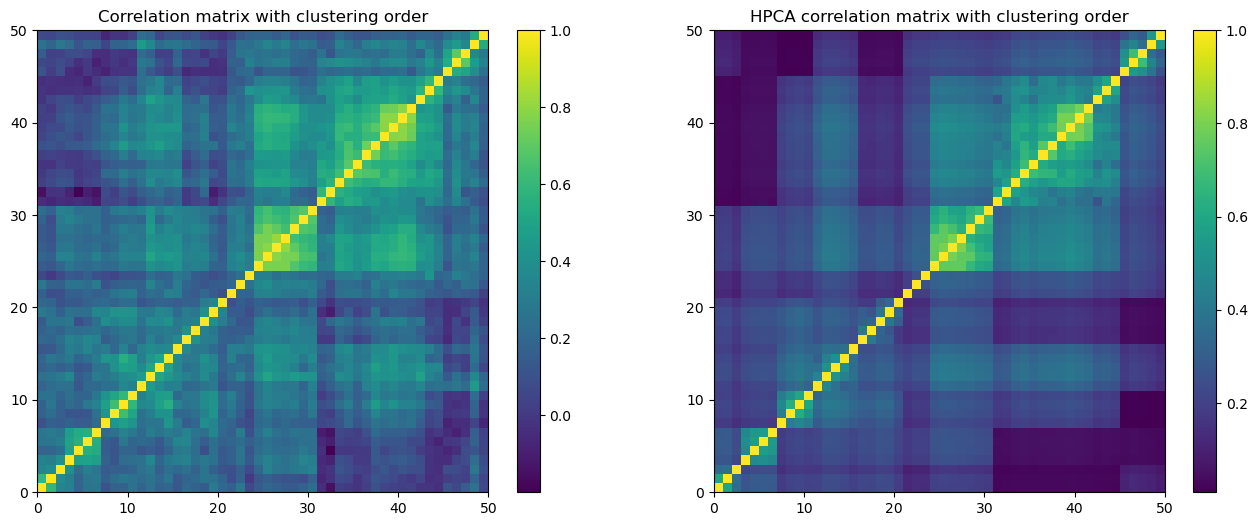

In [12]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(sorted_correlations)
plt.colorbar()
plt.title('Correlation matrix with clustering order')

plt.subplot(1, 2, 2)
plt.pcolormesh(HPCA_corr)
plt.colorbar()
plt.title('HPCA correlation matrix with clustering order')
plt.show()

In [13]:
### 相关系数矩阵的特征向量和特征值
eigenvals, eigenvecs = np.linalg.eig(sorted_correlations.values)

idx = eigenvals.argsort()[::-1]   
pca_eigenvals = eigenvals[idx]
pca_eigenvecs = eigenvecs[:, idx]

eigenvals, eigenvecs = np.linalg.eig(HPCA_corr.values)

idx = eigenvals.argsort()[::-1]   
hpca_eigenvals = eigenvals[idx]
hpca_eigenvecs = eigenvecs[:, idx]

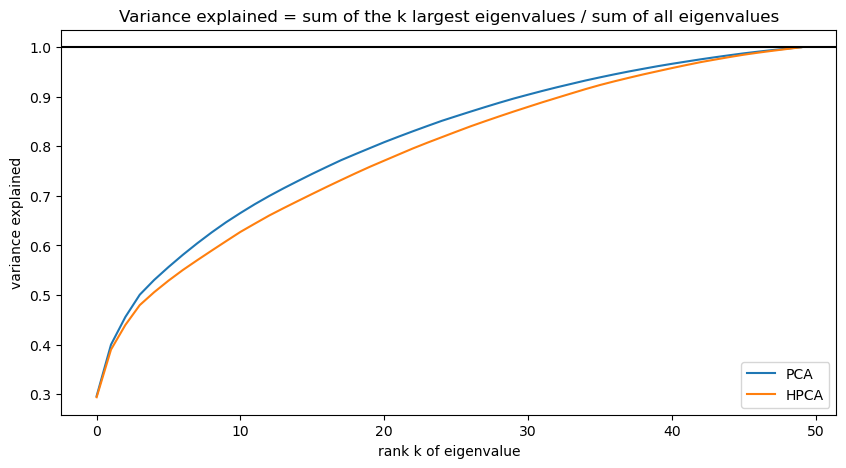

In [14]:
### 方差解释率折线图
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_eigenvals) / pca_eigenvals.sum(), label='PCA')
plt.plot(np.cumsum(hpca_eigenvals) / hpca_eigenvals.sum(), label='HPCA')
plt.axhline(1, color='k')
plt.xlabel('rank k of eigenvalue')
plt.ylabel('variance explained')
plt.title('Variance explained = ' +
          'sum of the k largest eigenvalues / sum of all eigenvalues')
plt.legend()
plt.show()
# 相比PCA，HPCA需要更多的组分来解释相同的方差值 （PCA总是使方差最大化，容易过拟合）

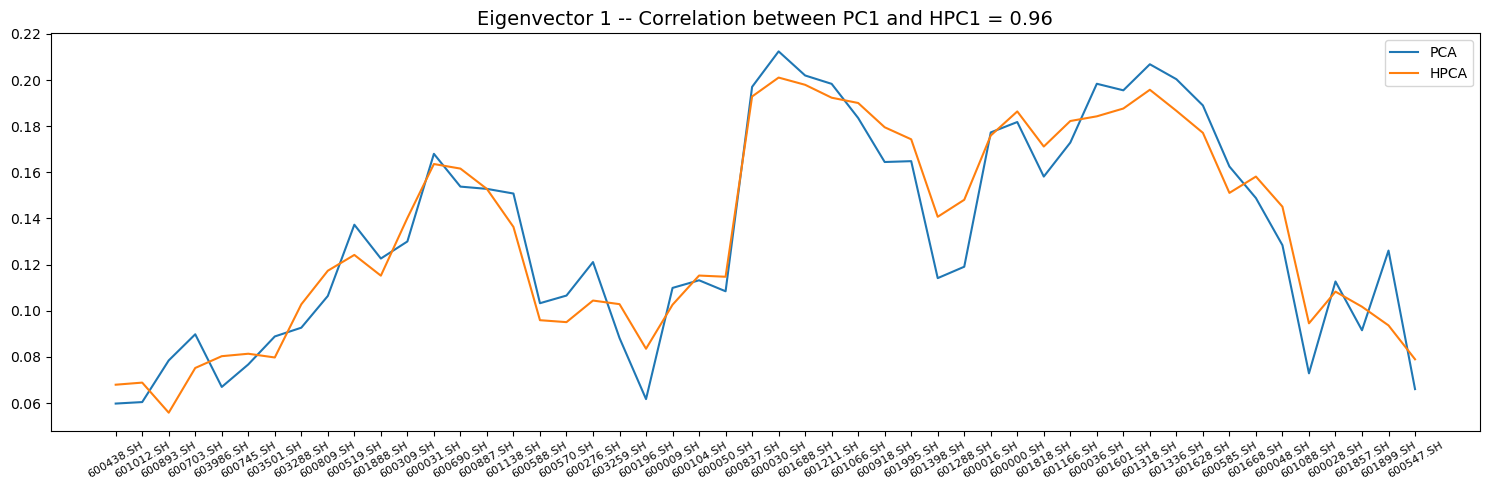

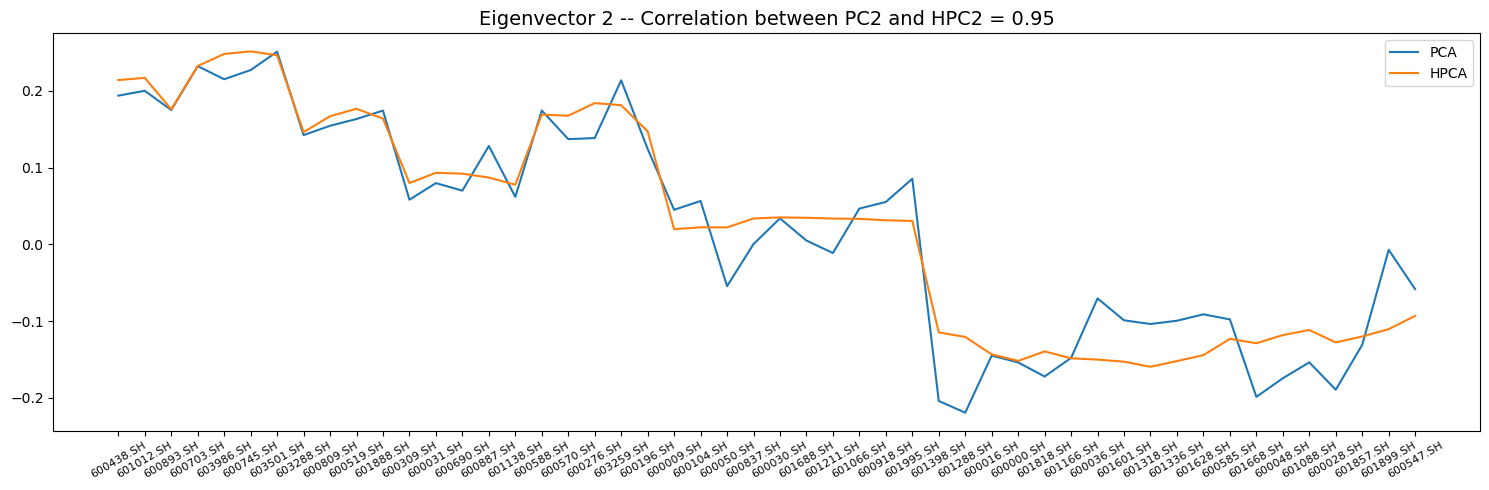

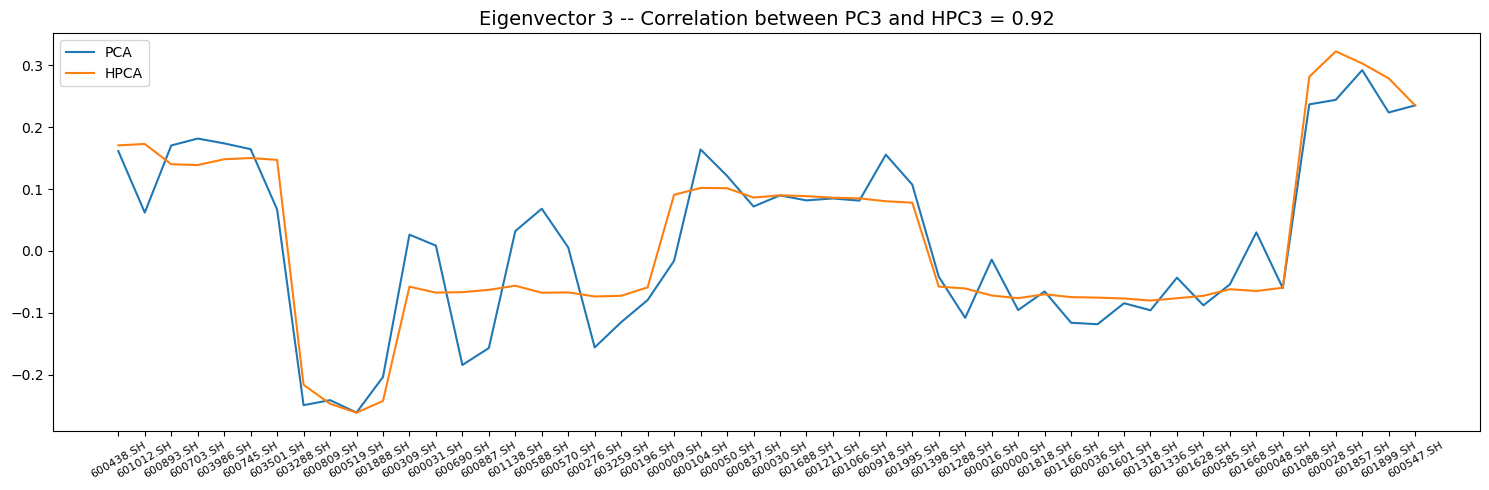

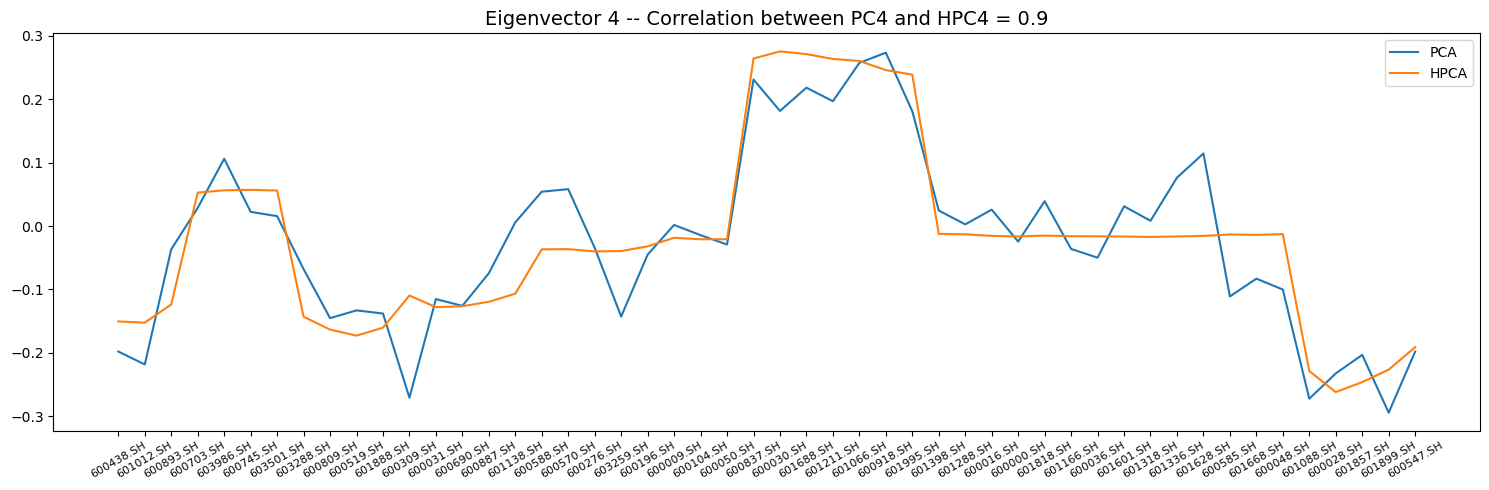

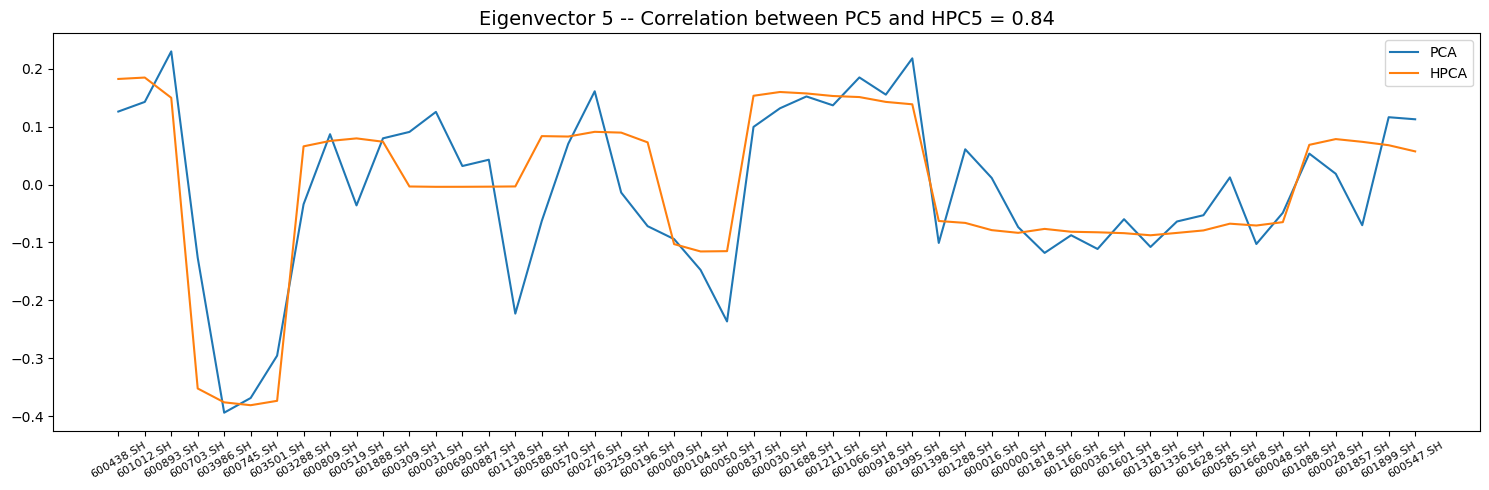

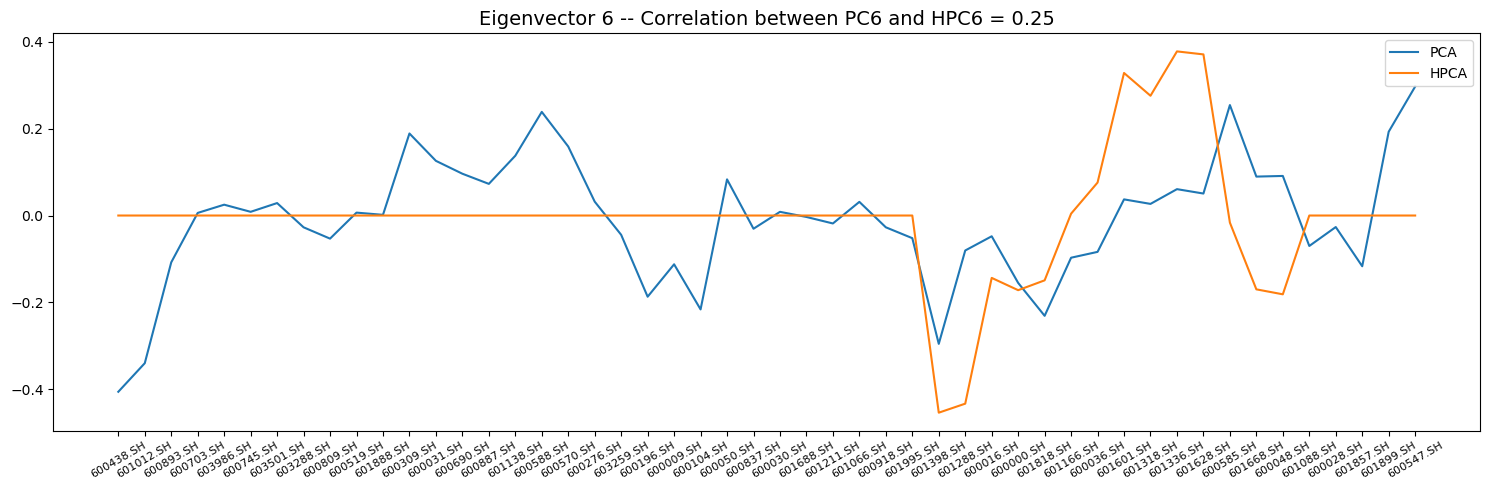

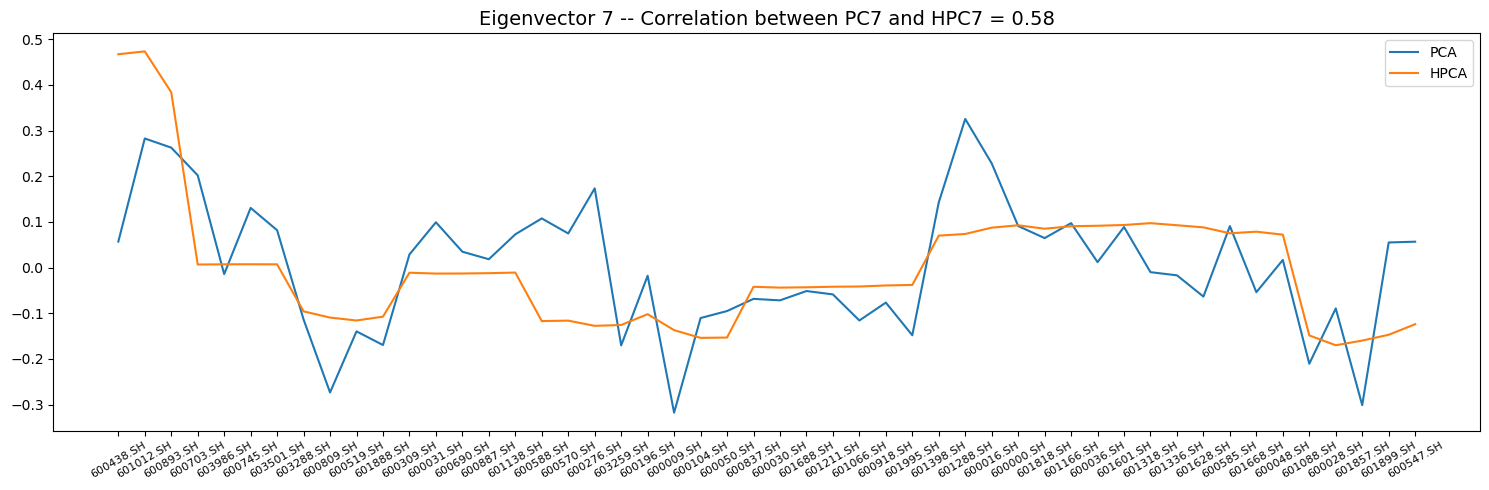

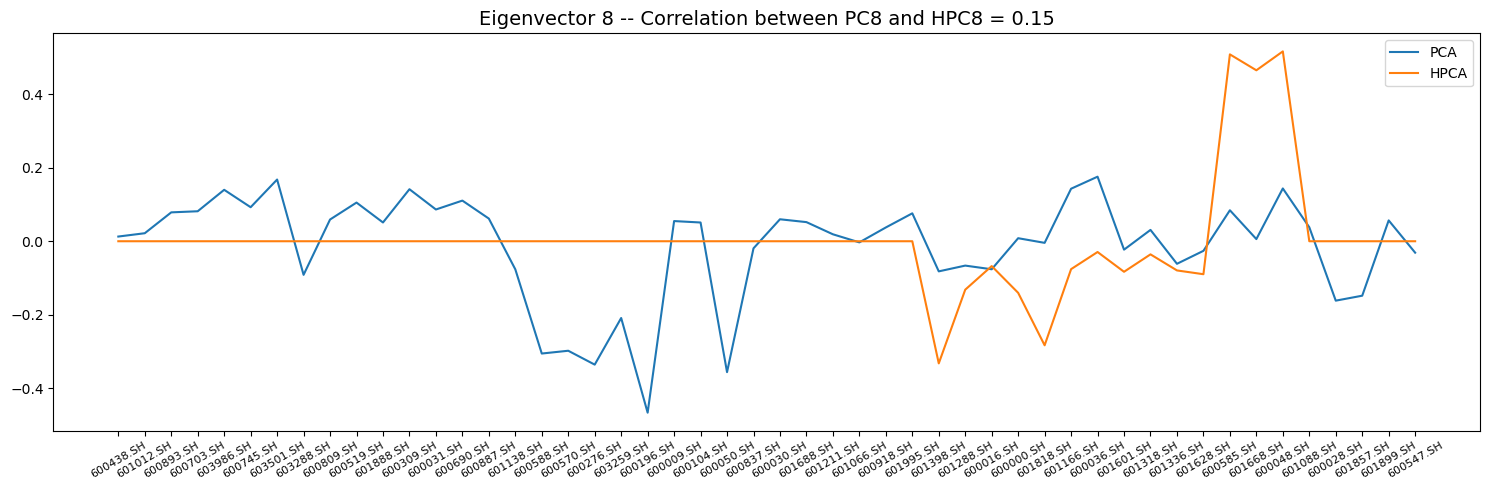

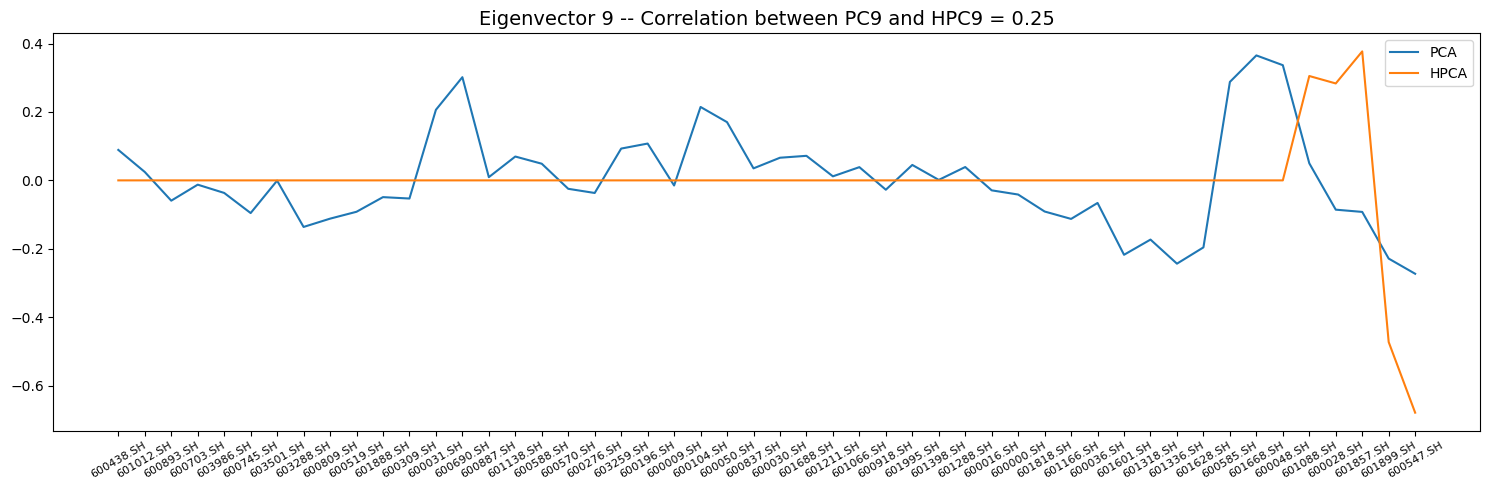

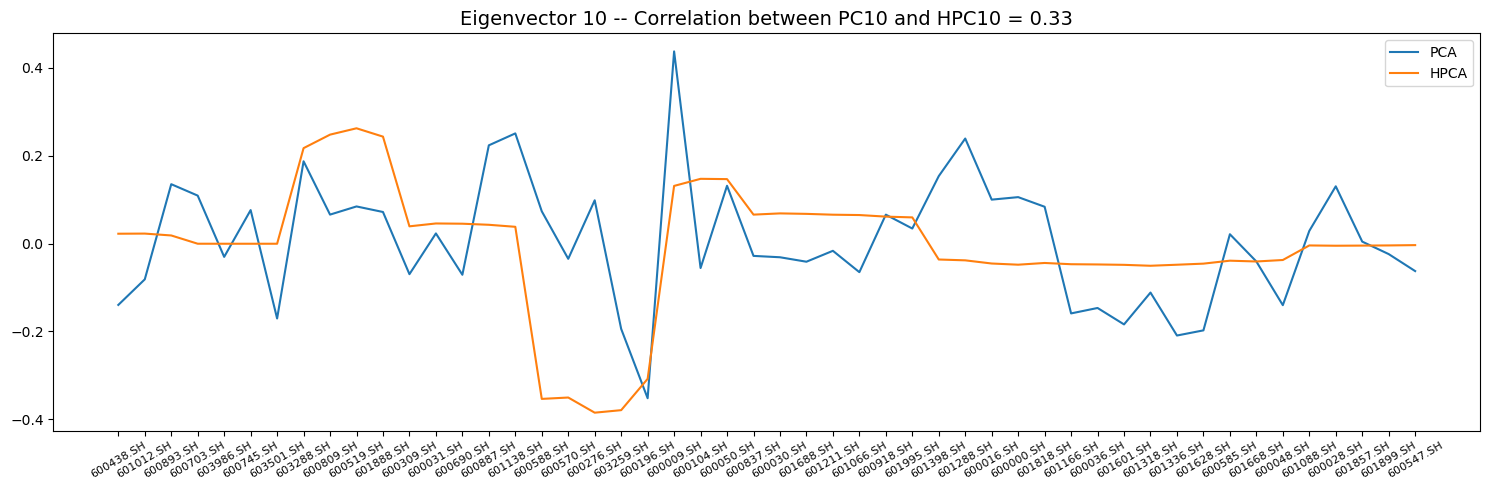

In [15]:
# 相关系数折线图比较
for i in range(10):
    fig, ax = plt.subplots(figsize=(15, 5),
                           tight_layout=True)
    corr_pcs = np.corrcoef(pca_eigenvecs[:, i],
                           hpca_eigenvecs[:, i])[0, 1]
    if corr_pcs < 0:
        hpca_eigenvecs[:, i] = -hpca_eigenvecs[:, i]

    plt.plot(pca_eigenvecs[:, i], label='PCA')
    plt.plot(hpca_eigenvecs[:, i], label='HPCA')
    plt.xticks(range(0,50), HPCA_corr.columns, rotation=30, fontsize=8)
    plt.title('Eigenvector {} -- '.format(i + 1) +
              'Correlation between PC{} and HPC{} = {}'.format(
        i + 1, i + 1, round(abs(corr_pcs), 2)), fontsize=14)
    plt.legend()
    plt.show()

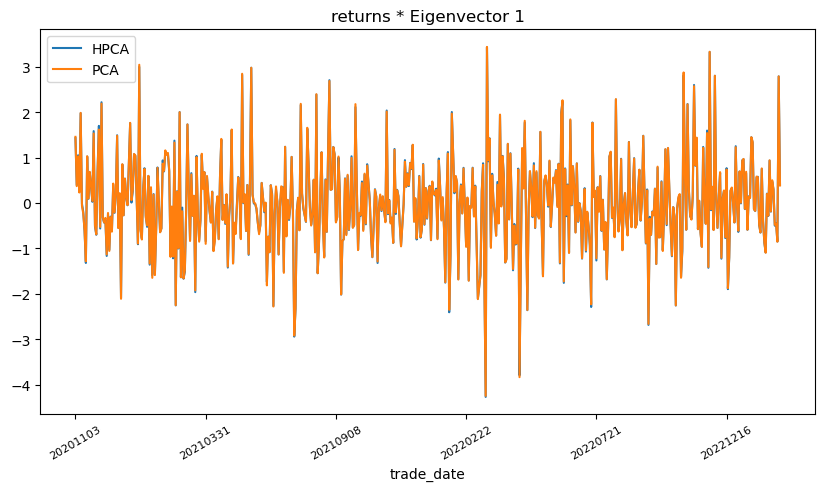

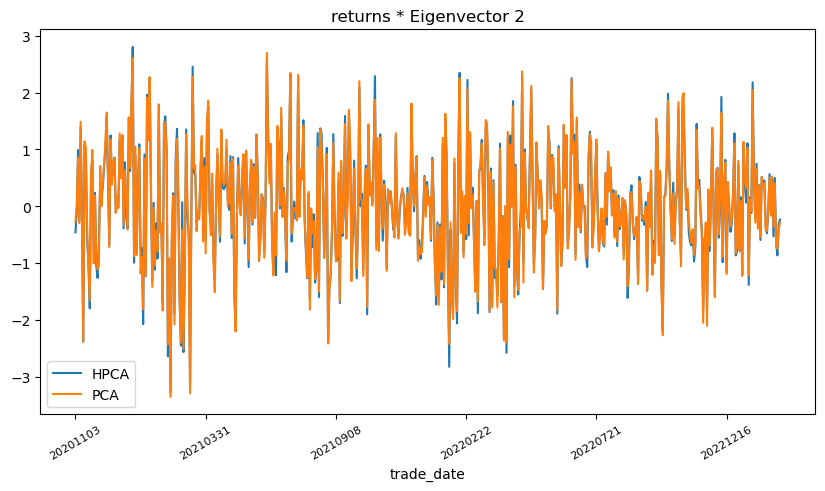

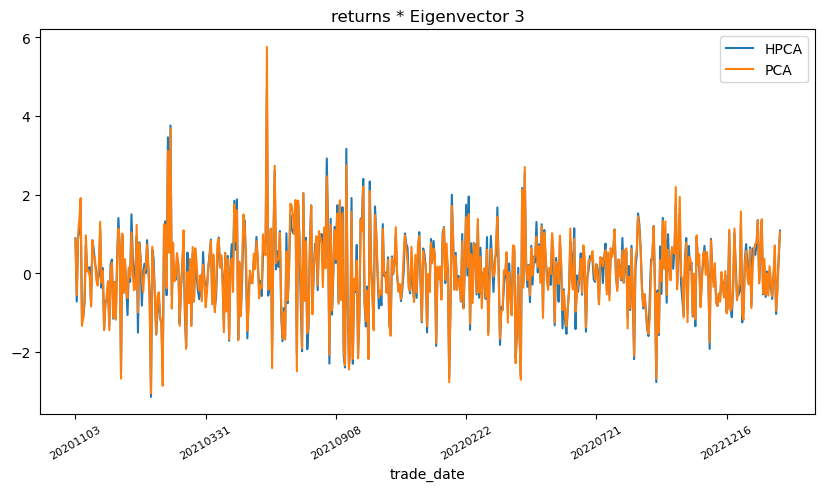

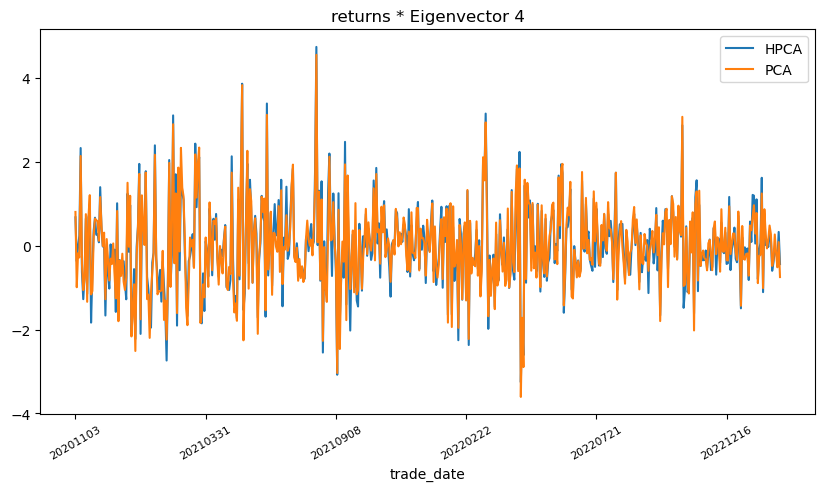

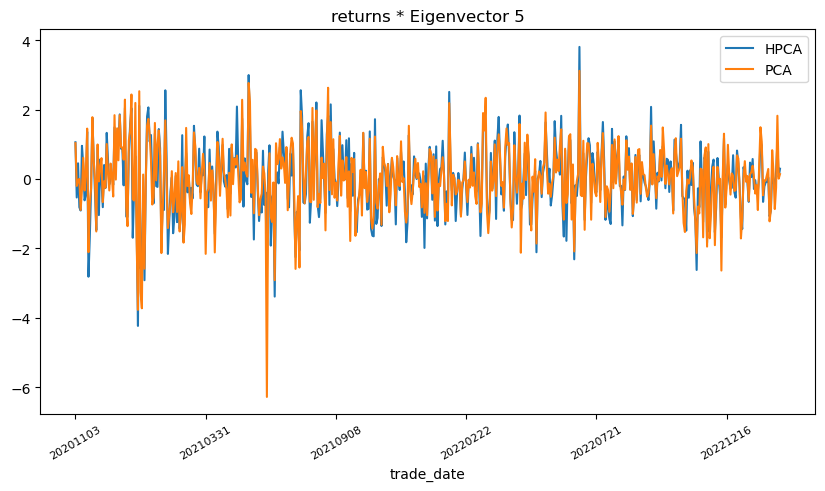

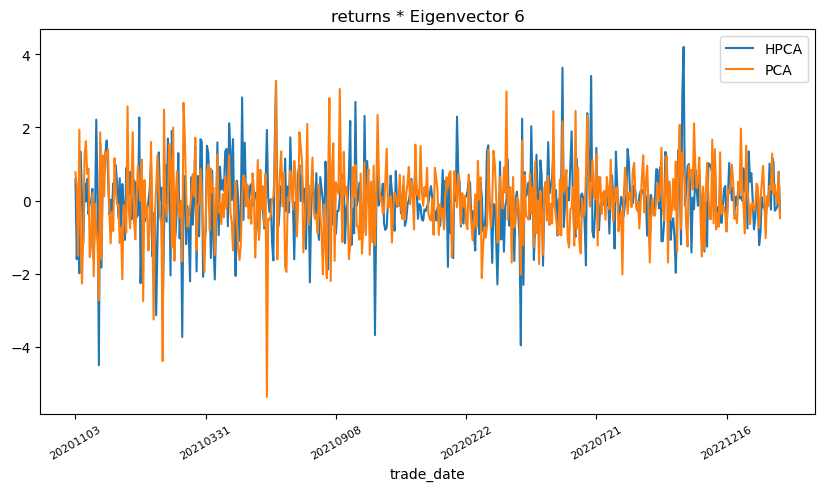

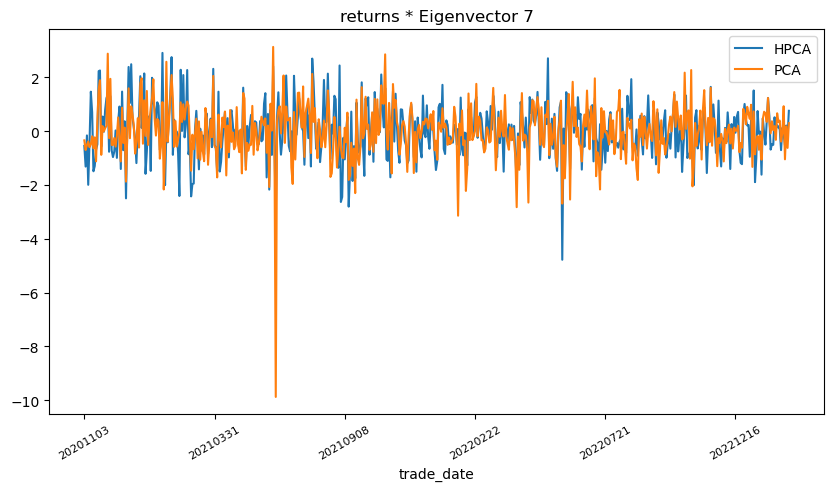

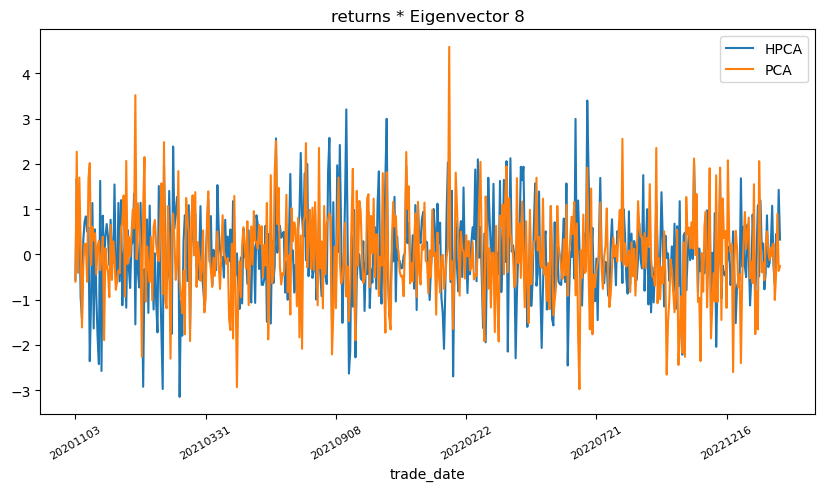

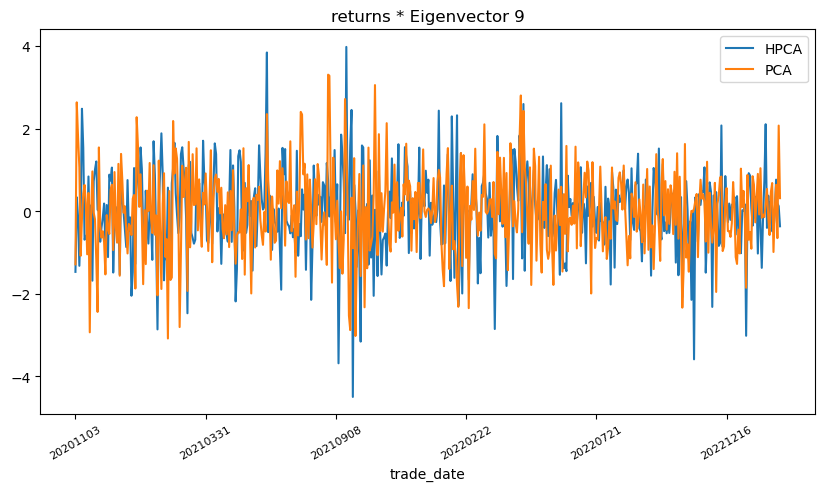

In [16]:
for i in range(1,10):
    f_p = pd.DataFrame(1/np.sqrt(pca_eigenvals[i-1])*np.dot(returns, pca_eigenvecs[:, i-1].T), index=returns.index)
    f_h = pd.DataFrame(1/np.sqrt(hpca_eigenvals[i-1])*np.dot(returns, hpca_eigenvecs[:, i-1].T), index=returns.index)
    f = pd.concat([f_h,f_p],axis=1)
    f.columns = ['HPCA','PCA']
    f.plot(figsize=(10,5))
    plt.xticks(rotation=30, fontsize=8)
    plt.title('returns * Eigenvector {}'.format(i))
plt.show()

In [18]:

import math
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr, ncol_inv_corr))
    for i in range(0, nrow_inv_corr, 1):
        for j in range(i, ncol_inv_corr, 1):
            A[i, j] = -(corr_inv[i, j]) / (math.sqrt(corr_inv[i, i] * corr_inv[j, j]))
            A[j, i] = A[i, j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

kmo(HPCA_corr)

0.9641398405298144